In [1]:
# See en.wikipedia.org/wiki/De_Casteljau's_algorithm and https://pomax.github.io/bezierinfo/
# And also https://www.youtube.com/watch?v=jvPPXbo87ds
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

def bezier(points: np.ndarray, x: float) -> np.ndarray:
    """Compute a point on a Bezier curve.

    Args:
        points: A 2D array of shape (n, 2) containing the control points.
        x: The parameter value at which to compute the point in [0, 1].

    Returns:
        A 1D array of shape (2,) containing the point on the curve.
    """
    n = points.shape[0] - 1
    if n == 0:
        return points[0]
    corner_cut_points = np.empty((n, 2))
    for i in range(n):
        current_point = points[i]
        vec_to_next_point = points[i + 1] - current_point
        corner_cut_points[i] = current_point + x * vec_to_next_point
    return bezier(corner_cut_points, x)

def bezier_curve(points: np.ndarray, num_points: int = 100) -> np.ndarray:
    """Compute a Bezier curve.

    Args:
        points: A 2D array of shape (n, 2) containing the control points.
        num_points: The number of points to compute on the curve.

    Returns:
        A 2D array of shape (num_points, 2) containing the points on the curve.
    """
    return np.array([bezier(points, x) for x in np.linspace(0, 1, num_points)]) 

In [6]:
def plot_curve(points: np.ndarray, curve: np.ndarray):
    plt.plot(curve[:, 0], curve[:, 1])
    plt.plot(points[:, 0], points[:, 1], "o--")
    for i, point in enumerate(points):
        plt.text(point[0] + 0.04, point[1], i+1)
    plt.show()

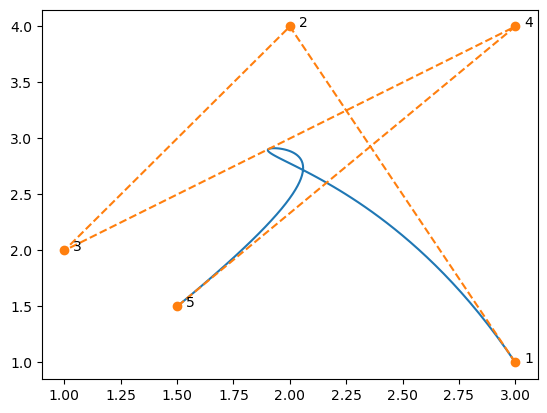

In [7]:
# draw a random ass shape
points = np.array([[3, 1], [2, 4], [1, 2], [3, 4], [1.5, 1.5]])
curve = bezier_curve(points)
plot_curve(points, curve)

In [123]:
def basis_fn(i: int, p: int, knots: np.ndarray, u: float) -> float:
    """
    See https://pages.mtu.edu/~shene/COURSES/cs3621/NOTES/spline/B-spline/bspline-property.html
    Args:
        i: knot span
        p: degree
        knots: knots in the shape (m)
        u: current location in the fn in [0, 1]
    """
    if p == 0:
        return 1 if knots[i] <= u < knots[i + 1] else 0
    def div(a: float, b: float) -> float:
        return 0 if np.isclose(a, 0) or np.isclose(b, 0) else a / b
    factor_lhs = div(u - knots[i], knots[i + p] - knots[i])
    lhs = basis_fn(i, p - 1, knots, u)
    factor_rhs = div(knots[i + p + 1] - u, knots[i + p + 1] - knots[i+1])
    rhs = basis_fn(i + 1, p - 1, knots, u)
    return factor_lhs * lhs + factor_rhs * rhs
        

def basis_fn_array(i: int, p: int, knots: np.ndarray, data_points: int = 100) -> np.ndarray:
    return np.array([basis_fn(i, p, knots, u) for u in np.linspace(0, 1, data_points)])
    

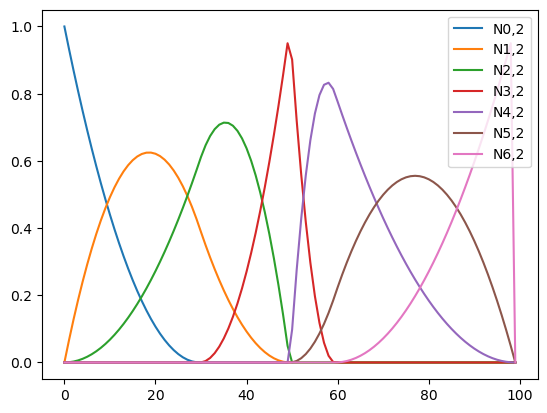

In [127]:
# Same values as https://pages.mtu.edu/~shene/COURSES/cs3621/NOTES/spline/B-spline/bspline-ex-1.html
knots = np.array([0., 0., 0., 0.3, 0.5, 0.5, 0.6, 1., 1., 1.], dtype = float)
for i in range(7):
    n = basis_fn_array(i, 2, knots)
    plt.plot(n)
plt.legend([f"N{i},2" for i in range(7)])
plt.show()

In [257]:
def de_boor(u: float, k: int, p: int, knots: np.ndarray, control_points: np.ndarray) -> np.ndarray:
    """
    Algorithm taken from https://pages.mtu.edu/~shene/COURSES/cs3621/NOTES/spline/B-spline/de-Boor.html
    Choose params such that m = n + p + 1.
    :param u: position on the curve in [knots[k], knots[k + p + 1])
    :param k: knot span
    :param p: degree
    :param knots: list of knots of shape (m)
    :param control_points: list of control points of shape (n, 2)
    :return: the point on the curve
    """
    assert knots[k] <= u < knots[k + p + 1], f"u = {u} not in [knots[k], knots[k + p + 1]) = [{knots[k]}, {knots[k + p + 1]})"
    assert knots.shape[0] == control_points.shape[0] + p + 1, f"m = {knots.shape[0]} != n + p + 1 = {control_points.shape[0] + p + 1}"
    
    to_insert = p
    s = 0
    if np.isclose(knots[k], u):
        multiplicity = np.count_nonzero(np.isclose(knots, u))
        to_insert -= multiplicity
        s = multiplicity
    if to_insert <= 0:
        return control_points[k - p]
    d = np.zeros((control_points.shape[0], to_insert + 1, 2))
    
    # points outside of this have a zero influence, so let's not compute them
    min = k - p
    max = k - s + 1
    
    d[min:max, 0] = control_points[min:max]
    for r in range(1, to_insert + 1):
        for i in range(min + r, max):
            alpha = (u - knots[i]) / (knots[i + p + 1 - r] - knots[i])
            d[i, r] = (1 - alpha) * d[i - 1, r - 1] + alpha * d[i, r - 1]
    return d[k - s, to_insert]

def b_spline(u: float, p: int, knots: np.ndarray, control_points: np.ndarray) -> np.ndarray:
    """
    :param u: position on the curve in [knots[p], knots[-p - 1])
    :param p: degree
    :param knots: list of knots of shape (m)
    :param control_points: list of control points of shape (n, 2)
    :return: the point on the curve of shape (2)
    """
    knots = knots / knots[-1] - knots[0] # rescale knots to [0, 1]
    assert np.all(np.diff(knots) >= 0), "knots must be non-decreasing"
    assert 0 <= u <= 1, f"u = {u} not in [0, 1]"
    assert 0 <= knots[0] and knots[-1] <= 1, f"internal error: knots must be in [0, 1]"
    for i in range(len(knots) - p - 1):
        if knots[i] <= u < knots[i + 1]:
            return de_boor(u, i, p, knots, control_points)
    raise ValueError(f"u = {u} not in [knots[p], knots[-p - 1]) = [{knots[p]}, {knots[-p - 1]})")

def b_spline_curve(p: int, knots: np.ndarray, control_points: np.ndarray, num_points: int = 100) -> np.ndarray:
    return np.array([b_spline(u, p, knots, control_points) for u in np.linspace(0, 1 - 1e-6, num_points)])
    

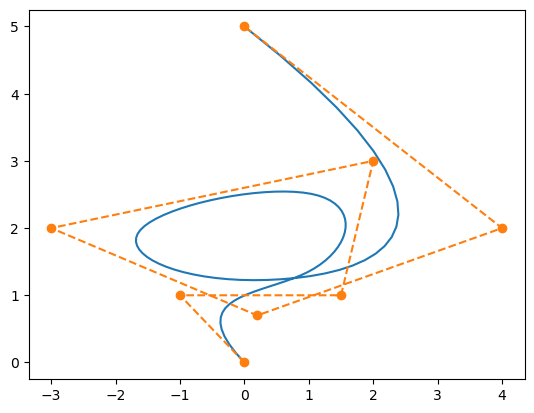

In [258]:
# draw a kind of rounded box
control_points = np.array([[0, 0], [-1, 1], [1.5, 1], [2, 3], [-3, 2], [0.2, 0.7], [4, 2], [0, 5]])
knots = np.array([0, 0, 0, 0, 1, 2, 3, 4, 5, 5, 5, 5], dtype = float)
curve = b_spline_curve(3, knots, control_points)
plt.plot(curve[:, 0], curve[:, 1])
plt.plot(control_points[:, 0], control_points[:, 1], "o--")
plt.show()


In [266]:
def de_boor_nurbs(u: float, k: int, p: int, knots: np.ndarray, control_points: np.ndarray) -> np.ndarray:
    """
    Algorithm taken from https://pages.mtu.edu/~shene/COURSES/cs3621/NOTES/spline/NURBS/NURBS-knot-insert.html
    Choose params such that m = n + p + 1.
    :param u: position on the curve in [knots[k], knots[k + p + 1])
    :param k: knot span
    :param p: degree
    :param knots: list of knots of shape (m)
    :param control_points: list of control points of shape (n, 3), where the last dimension is the weight
    :return: the point on the curve
    """
    assert knots[k] <= u < knots[k + p + 1], f"u = {u} not in [knots[k], knots[k + p + 1]) = [{knots[k]}, {knots[k + p + 1]})"
    assert knots.shape[0] == control_points.shape[0] + p + 1, f"m = {knots.shape[0]} != n + p + 1 = {control_points.shape[0] + p + 1}"
    
    to_insert = p
    s = 0
    if np.isclose(knots[k], u):
        multiplicity = np.count_nonzero(np.isclose(knots, u))
        to_insert -= multiplicity
        s = multiplicity
    if to_insert <= 0:
        return control_points[k - p]
    d = np.zeros((control_points.shape[0], to_insert + 1, control_points.shape[-1]))
    
    # points outside of this have a zero influence, so let's not compute them
    min = k - p
    max = k - s + 1
    
    d[min:max, 0] = control_points[min:max]
    
    # this is new in NURBS
    for i in range(min, max):
        weight = d[i, 0, -1]
        d[i, 0, 0:2] *= weight # change to homogenous coordinates
        
    for r in range(1, to_insert + 1):
        for i in range(min + r, max):
            alpha = (u - knots[i]) / (knots[i + p + 1 - r] - knots[i])
            d[i, r] = (1 - alpha) * d[i - 1, r - 1] + alpha * d[i, r - 1]
    return d[k - s, to_insert] / d[k - s, to_insert, -1] # NURBS: divide by weight to go back to euclidean coordinates

def nurbs(u: float, p: int, knots: np.ndarray, control_points: np.ndarray) -> np.ndarray:
    """
    :param u: position on the curve in [knots[p], knots[-p - 1])
    :param p: degree
    :param knots: list of knots of shape (m)
    :param control_points: list of control points of shape (n, 3), where the last dimension is the weight
    :return: the point on the curve of shape (2)
    """
    knots = knots / knots[-1] - knots[0] # rescale knots to [0, 1]
    assert np.all(np.diff(knots) >= 0), "knots must be non-decreasing"
    assert 0 <= u <= 1, f"u = {u} not in [0, 1]"
    assert 0 <= knots[0] and knots[-1] <= 1, f"internal error: knots must be in [0, 1]"
    for i in range(len(knots) - p - 1):
        if knots[i] <= u < knots[i + 1]:
            return de_boor_nurbs(u, i, p, knots, control_points)
    raise ValueError(f"u = {u} not in [knots[p], knots[-p - 1]) = [{knots[p]}, {knots[-p - 1]})")

def nurbs_curve(p: int, knots: np.ndarray, control_points: np.ndarray, num_points: int = 100) -> np.ndarray:
    return np.array([nurbs(u, p, knots, control_points) for u in np.linspace(0, 1 - 1e-6, num_points)])
    

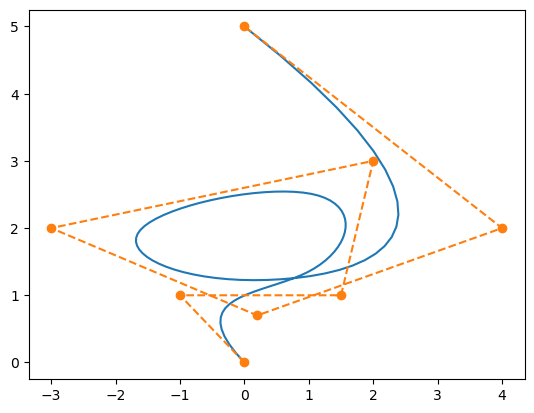

In [269]:
# draw a kind of rounded box
control_points = np.array([[0, 0, 1], [-1, 1, 1], [1.5, 1, 1], [2, 3, 1], [-3, 2, 1], [0.2, 0.7, 1], [4, 2, 1], [0, 5, 1]])
knots = np.array([0, 0, 0, 0, 1, 2, 3, 4, 5, 5, 5, 5], dtype = float)
curve = nurbs_curve(3, knots, control_points)
plt.plot(curve[:, 0], curve[:, 1])
plt.plot(control_points[:, 0], control_points[:, 1], "o--")
plt.show()


In [281]:
%matplotlib notebook
from ipywidgets import *

control_points = np.array([[0, 0, 1], [-1, 1, 1], [1.5, 1, 1], [2, 3, 1], [-3, 2, 1], [0.2, 0.7, 1], [4, 2, 1], [0, 5, 1]])
knots = np.array([0, 0, 0, 0, 1, 2, 3, 4, 5, 5, 5, 5], dtype = float)
curve = nurbs_curve(3, knots, control_points)
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(curve[:, 0], curve[:, 1])
ax.plot(control_points[:, 0], control_points[:, 1], "o--")
for i, point in enumerate(control_points):
    ax.text(point[0] + 0.04, point[1], i)

def update(w0 = 0.5, w1 = 0.5, w2 = 0.5, w3 = 0.5, w4 = 0.5, w5 = 0.5, w6 = 0.5, w7 = 0.5):
    # draw a kind of rounded box
    control_points = np.array([[0, 0, w0], [-1, 1, w1], [1.5, 1, w2], [2, 3, w3], [-3, 2, w4], [0.2, 0.7, w5], [4, 2, w6], [0, 5, w7]])
    curve = nurbs_curve(3, knots, control_points)
    line.set_xdata(curve[:, 0])
    line.set_ydata(curve[:, 1])
    fig.canvas.draw_idle()

interact(update, w0 = (0, 1, 0.01), w1 = (0, 1, 0.01), w2 = (0, 1, 0.01), w3 = (0, 1, 0.01), w4 = (0, 1, 0.01), w5 = (0, 1, 0.01), w6 = (0, 1, 0.01), w7 = (0, 1, 0.01))

<IPython.core.display.Javascript object>

interactive(children=(FloatSlider(value=0.5, description='w0', max=1.0, step=0.01), FloatSlider(value=0.5, des…

<function __main__.update(w0=0.5, w1=0.5, w2=0.5, w3=0.5, w4=0.5, w5=0.5, w6=0.5, w7=0.5)>